In [ ]:
from astropy import units as u

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import pandas as pd

In [ ]:
def m(size):
    # generate float number between 1 and 3 with size len(m)
    return np.random.uniform(1,3,size) * u.M_sun

In [ ]:
# Generating dataset
size = 100000

m1_lst = []
m2_lst = []

while len(m1_lst) < size:
    m1 = m(1)
    m2 = m(1)
    # if m1 > m2:
    m1_lst.append(m1)
    m2_lst.append(m2)
        
m1 = np.array(m1_lst) * u.M_sun
m2 = np.array(m2_lst) * u.M_sun

In [ ]:
# two plots side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(m1, bins=10, alpha=0.5, label='m1')
plt.xlabel(r'$m_1$ $[M_{\odot}]$')
plt.subplot(1,2,2)
plt.hist(m2, bins=10, alpha=0.5, label='m1')
plt.xlabel(r'$m_2$ $[M_{\odot}]$')
plt.savefig('histogram_BNS.png')

100%|██████████| 10000/10000 [00:28<00:00, 354.09it/s]


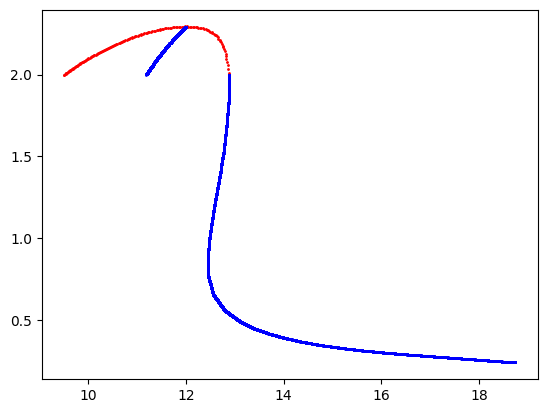

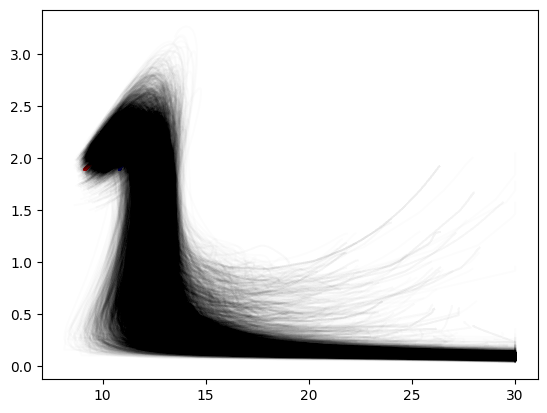

In [6]:
import h5py
from scipy.interpolate import interp1d
from tqdm import tqdm

infile = h5py.File('../LCEHL_EOS_posterior_samples_PSR+GW+NICER.h5', 'r')

m_grid = np.linspace(0.01, 3, 100000)
r_mat = np.zeros((len(infile['ns']),len(m_grid)))

i = 0

for i in tqdm(range(len(infile['ns']))):    
    # interpolate
    M = infile['ns']['eos_{0}'.format(i)]['M']
    R = infile['ns']['eos_{0}'.format(i)]['R']
    
    # find peak
    idx_flip = np.where(M == np.max(M))[0][0]
    idx_R_min = np.where(R == np.min(R))[0][0]

    # two intrapolations
    interpolator1 = interp1d(M[:idx_flip], R[:idx_flip], kind='linear', bounds_error=False)
    interpolator2 = interp1d(M[idx_flip:], R[idx_flip:], kind='linear', bounds_error=False)
    m_lower = m_grid[m_grid > M[idx_R_min]]
    m_upper = m_grid[m_grid <= M[idx_flip]]
    r_lower = interpolator2(m_lower)
    r_upper = interpolator1(m_upper)
    
    
    overlap_vals, overlap_lower_idx, overlap_upper_idx = np.intersect1d(m_lower, m_upper, return_indices=True)
    m_lower = np.delete(m_lower, overlap_lower_idx)
    r_upper[overlap_upper_idx] = (r_upper[overlap_upper_idx] + r_lower[overlap_lower_idx])/2
    r_lower = np.delete(r_lower, overlap_lower_idx)
    
    assert len(r_lower) + len(r_upper) == len(m_grid)
    
    r_mat[i] = np.concatenate((r_upper, r_lower))
    m_grid_test = np.concatenate((m_upper, m_lower))
    
    assert np.allclose(m_grid_test, m_grid)
    
    if i < 2:
        plt.figure()
        plt.scatter(infile['ns']['eos_{0}'.format(i)]['R'],infile['ns']['eos_{0}'.format(i)]['M'],c='red', s = 1)
        plt.scatter(r_mat[i], m_grid, c='blue', s = 1)
    else:
        pass
        
    plt.plot(infile['ns']['eos_{0}'.format(i)]['R'],infile['ns']['eos_{0}'.format(i)]['M'],c='k',alpha=0.01)
plt.show()

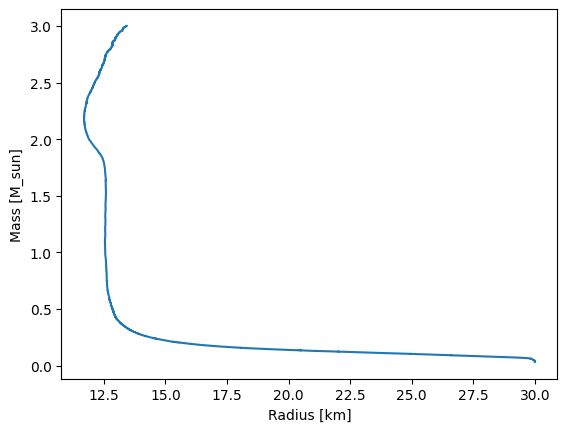

In [7]:
r_arr = m_grid.copy()
for i in range(len(m_grid)):
    if np.isnan(r_mat[:,i]).all():
        r_arr[i] = np.nan
        continue
        
    r_arr[i] = np.nanmean(r_mat[:,i])

plt.plot(r_arr, m_grid)
plt.xlabel("Radius [km]")
plt.ylabel("Mass [M_sun]")
r1_int = np.interp(m1.value, m_grid, r_arr) * u.km
r2_int = np.interp(m2.value, m_grid, r_arr) * u.km


Fraction of BNS systems with f_contact < f_ISCO: 0.000000


/var/folders/hr/fxn20ncj0qq2_mtm8k66bl7r0000gn/T/ipykernel_38449/830199210.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


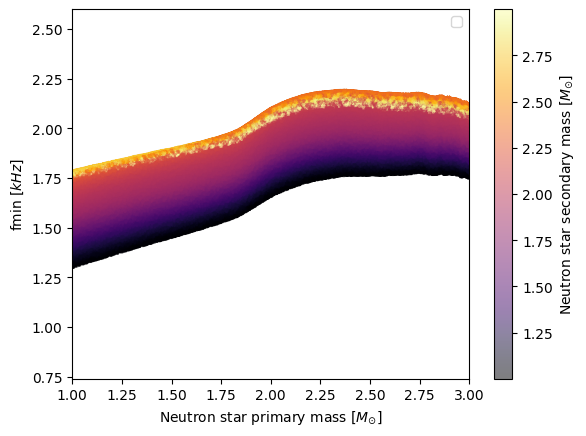

In [8]:
from astropy.constants import G, c

# a_val = 12.56 # median from arXiv:2106.05313 PSR+GW+NICER
# a = a_val * u.km
# r_avg = (r1_int + r2_int)/2
# a = r_avg
# num = (4*np.pi**2) * (2.*a)**3
# dem = G*(m1+m2)
# P = np.sqrt(num/dem)
# f_kepler = (1/P).to(u.Hz) # this is an orbital frequency (GW frequency would be double)
# f_contact = 2*f_kepler
# m_avg = (m1+m2)/2
# 
# lower = np.percentile(f_kepler, 5)
# upper = np.percentile(f_kepler, 95)
# median = np.percentile(f_kepler, 50)
# mean = np.mean(f_kepler)


f_ISCO = 1/(6**3/2) * 1/np.pi * 1/(m1+m2) * (c**3)/G

f_contact = (np.sqrt((m1+m2)/((r1_int+r2_int)**3) * G/(np.pi**2))).to(u.Hz) 

counter = 0

for i in range(len(f_contact)):
    if f_contact[i] < f_ISCO[i]:
        counter += 1

print(f"Fraction of BNS systems with f_contact < f_ISCO: {counter/len(f_contact):3f}")

f_min = np.minimum(f_ISCO.value, f_contact.value) * u.Hz

plt.figure()
plt.scatter(m1, f_min.to(u.kHz), alpha=0.5, s=10, marker = "1", c = m2.value, cmap = 'inferno')
plt.scatter(m2, f_min.to(u.kHz), alpha=0.5, s=10, marker = "1", c = m1.value, cmap = 'inferno')
plt.colorbar(label = r'Neutron star secondary mass $[M_{\odot}]$')
# strongest resonance occurs when f-mode frequency is twice orbital frequency, cf. arXiv:astro-ph/9812116
# so check if f-mode frequency is ever below twice orbital frequency at contact (which happens to be equal to the GW contact frequency)
plt.ylim(0.74, 2.6)
plt.xlim(1, 3)
plt.xlabel(r'Neutron star primary mass $[M_{\odot}]$')
plt.ylabel(r'fmin $[kHz]$')
plt.legend()
plt.savefig('contact_BNS.png')

In [9]:
df = pd.DataFrame({"m1": m1.value.squeeze(), "m2": m2.value.squeeze()})
# df['f_kepler'] = f_kepler.value.squeeze()
df['f_contact'] = (f_min).value.squeeze()
df.to_csv('contact_BNS.csv')

In [10]:
df

,m1,m2,f_contact
0,2.582324,1.444054,1874.912426
1,2.794694,1.089913,1797.041470
2,2.029068,1.187124,1727.023064
3,2.839905,1.384494,1859.539154
4,1.343418,1.669155,1597.683351
...,...,...,...
99995,1.221190,1.734778,1585.847580
99996,1.495968,1.463360,1581.049970
99997,2.640157,2.820320,2135.385261
99998,1.692229,2.307153,1932.151589
